In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#Data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

##### First look of our data

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h5>Example of Submission</h5>

Given the passengerID, We are looking to predict whether a passenger survived or not. 

In [4]:
submission_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
submission_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


#### **Feature Analysis**

In [5]:
train_data.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

**Categorical Features**
Categorical: Survived, Sex, and Embarked.
Ordinal: Pclass.

**Numerical Features**
Continous: Age, Fare.
Discrete: SibSp, Parch.

#### **Data Distribution**

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Around 38% samples survived representative of the actual survival rate at 32%.
* Most passengers (> 75%) did not travel with parents or children.
* Nearly 30% of the passengers had siblings and/or spouse aboard.
* Fares varied significantly with few passengers (<1%) paying as high as $512.
* Age is missing for 177 passengers, we need to find a way to fix this.

In [7]:
train_data.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fischer, Mr. Eberhard Thelander",male,1601,B96 B98,S
freq,1,577,7,4,644


* All the traveller names are unique. 
* There are only two types of sex, Male and Female. Male population represents 65%.
* There are many duplicates in cabin and many people could be in shared cabin. This feature might not be of use in our models.
* Embarked is classified into three types and most of them belong to S.
* There were many duplicates in the Ticket, only 77% had unique tickets.

**Total Missing Values**

In [8]:
def na_values(data):
    report = data.isna().sum().to_frame()
    report = report.rename(columns = {0: 'missing_values'})
    report = report.loc[report['missing_values'] != 0]
    report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
    return report.sort_values(by = 'missing_values', ascending = False)

In [9]:
na_values(train_data)

,missing_values,% of total
Cabin,687,0.77
Age,177,0.20
Embarked,2,0.00


In [10]:
na_values(test_data)

,missing_values,% of total
Cabin,327,0.78
Age,86,0.21
Fare,1,0.00


#### **Data Visualizations**

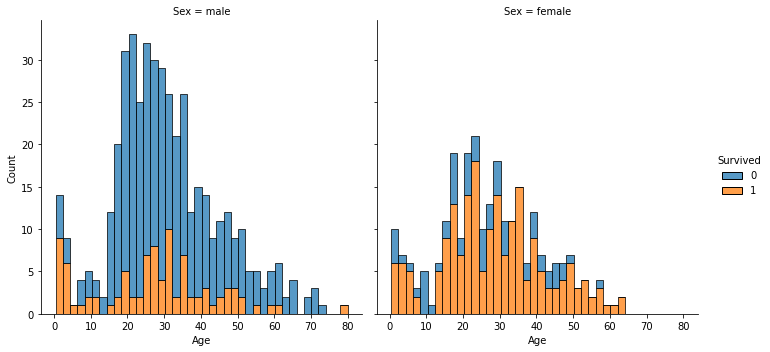

In [11]:
ax = sns.displot(train_data,x = "Age", bins=40, hue = "Survived", col = "Sex", multiple = "stack")

In [12]:
for template in ["none"]:
    fig = px.scatter(train_data,
                     x="PassengerId", y="Age", color="Survived",
                     log_x=True, size_max=20,
                     template=template, title="Survival by Age")
    fig.show()

* Infants had the highest survival rate.
* Many people in the age range 15-35 did not survive.
* All oldest( age = 80) passengers survived. 

##### Pclass, Sex, Embarked and Survival

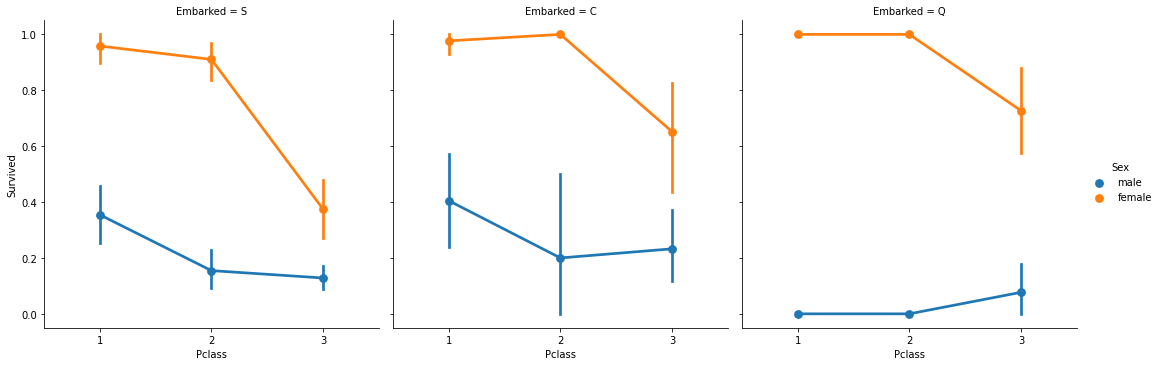

In [13]:
g = sns.catplot(x="Pclass", y='Survived', hue="Sex",
                   col='Embarked', data=train_data,kind ='point')

* Female passengers who embarked on Southampton and travelled in third class had the lowest survival rate.
* Male passengers who embarked on Cherbourg, France had the best survival rate. 

##### Sex, Fare, Embarked and Survived

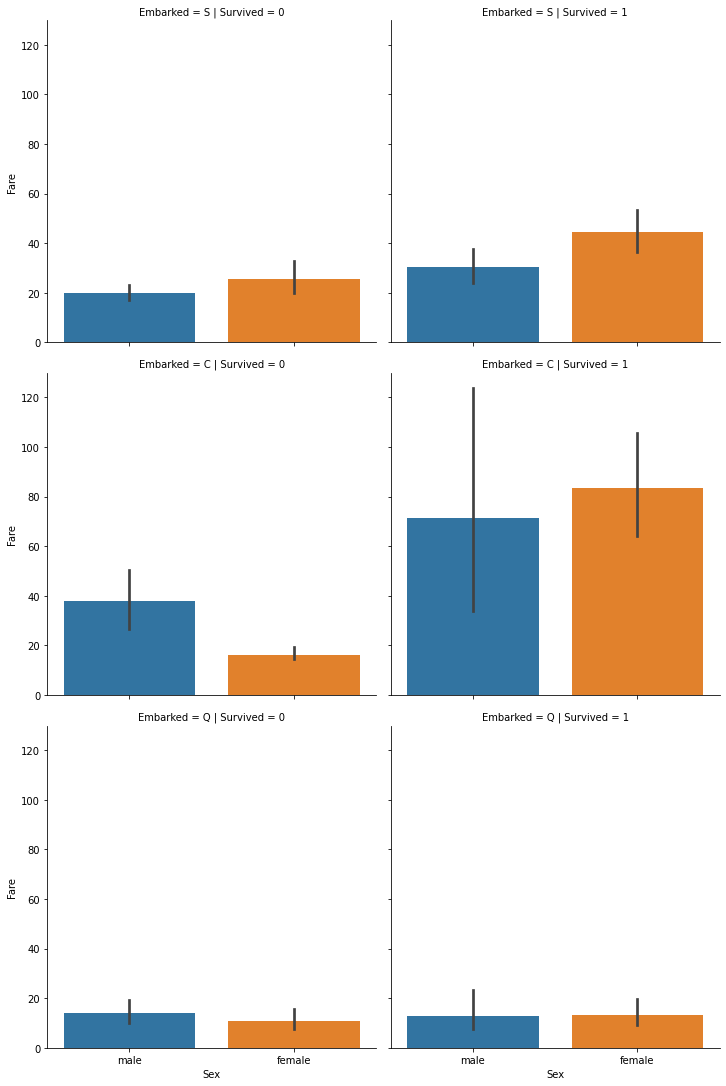

In [14]:
g = sns.catplot(x="Sex", y='Fare', row="Embarked",
                   col='Survived', data=train_data,kind ='bar')

* Passengers who paid high fares had high survival rates. 
* Passengers who boarded on the port C (Cherbug) had better survival rate. 

##### Age, Embarked, Pclass, Sex and Survival

<AxesSubplot:xlabel='Sex', ylabel='Age'>

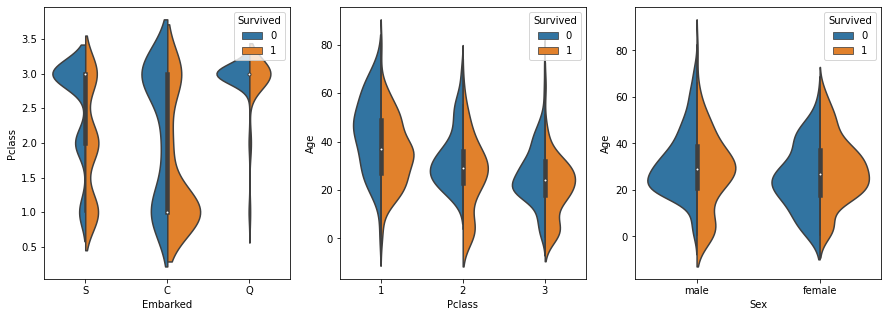

In [15]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.violinplot(x="Embarked", y="Pclass", hue="Survived", data=train_data, split=True, ax=ax1)
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train_data, split=True, ax=ax2)
sns.violinplot(x="Sex", y="Age", hue="Survived", data=train_data, split=True, ax=ax3)

From Pclass violinplot, we can see that:

* 1st Pclass had very few children as compared to other two classes.
* 1st Pclass had more old people as compared to other two classes.
* Almost all children (between age 0 to 10) of 2nd Pclass survived.
* Most children of 3rd Pclass survived.
* Younger people of 1st Pclass survived as compared to its older people.
* All first class and second class passengers embarked on Southhampton or Cherbourg.

From Sex violinplot, we can see that:

* Most male children (between age 0 to 14) survived.
* Females with age between 18 to 40 had better survival rate.
* Combining both male and female, we can see that children with age between 0 to 5 had better chance of survival.

#### **Correlation**

We need to find **Correlation** between variables. Correlation simply refers to how close two variables are to having a linear relationship with each other.  

**Remember Correlation does really mean Causation**

In [16]:
train_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


#### Pclass vs Survival

In [17]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


More than 50% of passengers from first class survived.

#### Sex vs Survival

Let us confirm the correlation between sex and the survival rate. It is mentioned in the question that female passengers are more likely to survive than male.

In [18]:
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


* The assumption is True. Looks like around 75% of female passengers survived.

##### SibSp vs Survival

In [19]:
train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


##### Parch vs Survival

In [20]:
train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


* We could see zero correlation between some values of Parch or Sibsp.We might need to find some way to combine them into a single feature. 

### **Feature Engineering**

##### Cabin

We can extract some important details related to passenger seating from cabin. So, let us extract the cabin's first letter.

In [21]:
print(train_data[train_data['Cabin'].notnull()].Cabin.str.extract('^([A-Za-z])', expand=False).unique())
print(train_data[train_data['Cabin'].notnull()].Cabin.str.extract('^([A-Za-z])', expand=False).describe())

['C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
count     204
unique      8
top         C
freq       59
Name: Cabin, dtype: object


* Looks like most of the passengers (59) were in cabin series that starts from 'C'.
* There were 8 unique cabin series.

In [22]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [23]:
train_data, test_data = cabin(train_data, test_data)

In [24]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,n
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,n
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,n


##### **Name**

In [25]:
train_data['Title'] = train_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [26]:
pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [27]:
pd.crosstab(test_data['Title'], test_data['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [28]:
# Grouping some of the rarely occuring Titles
def name_group(x):
    if x in ["Mr", "Sir" ]:
        return 'Mr'
    if x in ["Mrs", "Mme"]:
        return 'Mrs'
    if x in ["Mlle", "Ms", "Miss"]:
        return 'Miss'
    if x in ["Master"]:
        return 'Master'
    else:
        return 'Rare'

In [29]:
train_data['Title'] = train_data['Title'].apply(name_group)
test_data['Title'] = test_data['Title'].apply(name_group)

In [30]:
print(train_data['Title'].unique())
print(test_data['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']


We see some correlation between the name length and the survival.

In [31]:
def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        del i['Name']
    return train, test

In [32]:
train_data, test_data = names(train_data, test_data)

In [33]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Letter,Title,Name_Len
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,n,Mr,23
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,51
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,n,Miss,22
3,4,1,1,female,35.0,1,0,113803,53.1000,S,C,Mrs,44
4,5,0,3,male,35.0,0,0,373450,8.0500,S,n,Mr,24


##### **Ticket**

* Ticket might help us with some details regarding seating of the passengers.
* Ticket length will provide information regarding the type of ticket distributed.

In [34]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

In [35]:
train_data, test_data = ticket_grouped(train_data, test_data)

In [36]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Letter,Title,Name_Len,Ticket_Lett,Ticket_Len
0,1,0,3,male,22.0,1,0,7.2500,S,n,Mr,23,A,9
1,2,1,1,female,38.0,1,0,71.2833,C,C,Mrs,51,P,8
2,3,1,3,female,26.0,0,0,7.9250,S,n,Miss,22,S,16
3,4,1,1,female,35.0,1,0,53.1000,S,C,Mrs,44,1,6
4,5,0,3,male,35.0,0,0,8.0500,S,n,Mr,24,3,6


##### **Sibsp and Parch**

When we have two seemingly weak predictors, one thing we can do is combine them to get a stronger predictor. 

* We can create a new feature "Family Size" to account for the Family size.
* It can be a categorical variable and also help differentiate solo travellers. 

In [37]:
def fam_size(train, test):
    for i in [train, test]:
        i['Family_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test

In [38]:
train_data, test_data = fam_size(train_data, test_data)

In [39]:
train_data[['Family_Size', 'Survived']].groupby(['Family_Size'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family_Size,Survived
1,Nuclear,0.578767
2,Solo,0.303538
0,Big,0.161290


* Big families are the least likelist to survive.

In [40]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Cabin_Letter,Title,Name_Len,Ticket_Lett,Ticket_Len,Family_Size
0,1,0,3,male,22.0,7.2500,S,n,Mr,23,A,9,Nuclear
1,2,1,1,female,38.0,71.2833,C,C,Mrs,51,P,8,Nuclear
2,3,1,3,female,26.0,7.9250,S,n,Miss,22,S,16,Solo
3,4,1,1,female,35.0,53.1000,S,C,Mrs,44,1,6,Nuclear
4,5,0,3,male,35.0,8.0500,S,n,Mr,24,3,6,Solo


##### **Embarked**

We have one missing value in Embarked, so fixing it with the mode.

In [41]:
freq_port = train_data.Embarked.dropna().mode()[0]
freq_port

'S'

In [42]:
train_data['Embarked'] = train_data['Embarked'].fillna(freq_port)

In [43]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [44]:
train_data['Embarked'].isnull().sum()

0

##### **Fare**

We have one Fare value missing in the test data. We can replace it with the mean value from the train dataset.

In [45]:
test_data['Fare'].fillna(train_data['Fare'].mean(), inplace = True)

In [46]:
test_data['Fare'].isnull().sum()

0

**Age**

* We impute the null values of the Age column by filling in the mean value of the passenger’s corresponding title and class.

In [47]:
train_data['Age_mean'] = train_data.groupby(['Title', 'Pclass'])['Age'].transform('mean')

In [48]:
train_data[['Title','Pclass','Age_mean', 'Survived']].groupby(['Title', 'Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Pclass,Age_mean,Survived
0,Master,1,5.306667,1.000000
1,Master,2,2.258889,1.000000
9,Mrs,1,40.400000,0.976744
3,Miss,1,29.744681,0.958333
4,Miss,2,22.560606,0.942857
10,Mrs,2,33.682927,0.902439
5,Miss,3,16.123188,0.500000
11,Mrs,3,33.515152,0.500000
12,Rare,1,47.461538,0.500000
2,Master,3,5.350833,0.392857


We can now replace the missing values of Age with the mean value in the training data.

In [49]:
train_data['Age'] = train_data['Age'].fillna(train_data['Age_mean'])

Merging the Test data with Train data using Left join, that means, if the keys(Title and Pclass) are not present in test data, it is filled with NaN's rather than removing the records. 

In [50]:
Merge_Test_Train = test_data.merge(train_data, on=['Title', 'Pclass'], how='left').drop_duplicates(['PassengerId_x'])

In [51]:
test_data['Age'] = np.where(test_data['Age'].isnull(), Merge_Test_Train['Age_mean'], test_data['Age'])

##### **Dropping some Features**

In [52]:
train = train_data.drop(['PassengerId', 'Age_mean'], axis=1)

In [53]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Cabin_Letter,Title,Name_Len,Ticket_Lett,Ticket_Len,Family_Size
0,0,3,male,22.0,7.2500,S,n,Mr,23,A,9,Nuclear
1,1,1,female,38.0,71.2833,C,C,Mrs,51,P,8,Nuclear
2,1,3,female,26.0,7.9250,S,n,Miss,22,S,16,Solo
3,1,1,female,35.0,53.1000,S,C,Mrs,44,1,6,Nuclear
4,0,3,male,35.0,8.0500,S,n,Mr,24,3,6,Solo


##### **Categorical Feature Encoding**

In [54]:
cat_features_list = ['Pclass','Sex','Embarked', 'Ticket_Lett', 'Cabin_Letter','Title', 'Family_Size']

In [55]:
def dummies(train, test, columns = cat_features_list):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [56]:
#train, test = dummies(train, test_data, cat_features_list)

In [57]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Cabin_Letter,Title,Name_Len,Ticket_Lett,Ticket_Len,Family_Size
0,0,3,male,22.0,7.2500,S,n,Mr,23,A,9,Nuclear
1,1,1,female,38.0,71.2833,C,C,Mrs,51,P,8,Nuclear
2,1,3,female,26.0,7.9250,S,n,Miss,22,S,16,Solo
3,1,1,female,35.0,53.1000,S,C,Mrs,44,1,6,Nuclear
4,0,3,male,35.0,8.0500,S,n,Mr,24,3,6,Solo


In [58]:
#train[cat_features_list] = OrdinalEncoder().fit_transform(train[cat_features_list])
#test[cat_features_list] = OrdinalEncoder().fit_transform(test[cat_features_list])

##### **Mean Encoding**

In [59]:
from sklearn.model_selection import StratifiedKFold
from itertools import product

class MeanEncoder:
    
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        categorical_features: list of str, the name of the categorical columns to encode
        n_splits: the number of splits used in mean encoding
        target_type: str, 'regression' or 'classification'
        prior_weight_func: a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope        
        """
        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}
        
        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None
            
        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))
            
    
    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()
        
        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()
        
        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg([('mean', 'mean'), ('beta', 'size')])
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)
        
        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y
    
    def fit_transform(self, X, y):
        """
        :X: pandas DataFrame, n_samples * n_features
        :y: pandas Series or numpy array, n_samples
        :X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)
        
        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new
            
    
    def transform(self, X):
        """
        :X: pandas DataFrame, n_samples * n_features
        :X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        
        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new
            

In [60]:
enc=MeanEncoder(['Pclass', 'Sex', 'Embarked', 'Ticket_Lett','Cabin_Letter','Title', 'Family_Size'])

In [61]:
temp=enc.fit_transform(train.iloc[:,1:],train.iloc[:,0])
temp

,Pclass,Sex,Age,Fare,Embarked,Cabin_Letter,Title,Name_Len,Ticket_Lett,Ticket_Len,...,Embarked_pred_0,Embarked_pred_1,Ticket_Lett_pred_0,Ticket_Lett_pred_1,Cabin_Letter_pred_0,Cabin_Letter_pred_1,Title_pred_0,Title_pred_1,Family_Size_pred_0,Family_Size_pred_1
0,3,male,22.000000,7.2500,S,n,Mr,23,A,9,...,0.663443,0.336557,0.904762,0.095238,0.707721,0.292279,0.834515,0.165485,0.392070,0.607930
1,1,female,38.000000,71.2833,C,C,Mrs,51,P,8,...,0.410448,0.589552,0.313725,0.686275,0.408163,0.591837,0.193878,0.806122,0.392070,0.607930
2,3,female,26.000000,7.9250,S,n,Miss,22,S,16,...,0.663443,0.336557,0.666667,0.333333,0.707721,0.292279,0.310345,0.689655,0.709751,0.290249
3,1,female,35.000000,53.1000,S,C,Mrs,44,1,6,...,0.663443,0.336557,0.360000,0.640000,0.408163,0.591837,0.193878,0.806122,0.392070,0.607930
4,3,male,35.000000,8.0500,S,n,Mr,24,3,6,...,0.663443,0.336557,0.788793,0.211207,0.707721,0.292279,0.834515,0.165485,0.709751,0.290249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.000000,13.0000,S,n,Rare,21,2,6,...,0.664062,0.335938,0.528571,0.471429,0.693841,0.306159,0.666667,0.333333,0.690307,0.309693
887,1,female,19.000000,30.0000,S,B,Miss,28,1,6,...,0.664062,0.335938,0.389381,0.610619,0.250000,0.750000,0.288462,0.711538,0.690307,0.309693
888,3,female,16.123188,23.4500,S,n,Miss,40,W,10,...,0.664062,0.335938,0.777631,0.222369,0.693841,0.306159,0.288462,0.711538,0.441667,0.558333
889,1,male,26.000000,30.0000,C,C,Mr,21,1,6,...,0.463235,0.536765,0.389381,0.610619,0.450980,0.549020,0.837709,0.162291,0.690307,0.309693


In [62]:
temp.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Cabin_Letter', 'Title',
       'Name_Len', 'Ticket_Lett', 'Ticket_Len', 'Family_Size', 'Pclass_pred_0',
       'Pclass_pred_1', 'Sex_pred_0', 'Sex_pred_1', 'Embarked_pred_0',
       'Embarked_pred_1', 'Ticket_Lett_pred_0', 'Ticket_Lett_pred_1',
       'Cabin_Letter_pred_0', 'Cabin_Letter_pred_1', 'Title_pred_0',
       'Title_pred_1', 'Family_Size_pred_0', 'Family_Size_pred_1'],
      dtype='object')

In [63]:
columns=['Age', 'Fare', 'Name_Len','Ticket_Len','Pclass_pred_1','Sex_pred_1','Embarked_pred_1',
         'Ticket_Lett_pred_1','Cabin_Letter_pred_1','Title_pred_1','Family_Size_pred_1']

In [64]:
train_encoded=temp[columns]
test_encoded=enc.transform(test_data)[columns]

##### **Standardizing Age and Fare**

In [65]:
num_features_list = ['Age', 'Fare', 'Name_Len', 'Ticket_Len']

In [66]:
scaler = StandardScaler()
scaler.fit(train[num_features_list])
train_encoded[num_features_list] = scaler.transform(train[num_features_list])
scaler.fit(test_data[num_features_list])
test_encoded[num_features_list] = scaler.transform(test_data[num_features_list])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
train_encoded.head()

,Age,Fare,Name_Len,Ticket_Len,Pclass_pred_1,Sex_pred_1,Embarked_pred_1,Ticket_Lett_pred_1,Cabin_Letter_pred_1,Title_pred_1,Family_Size_pred_1
0,-0.548516,-0.502445,-0.427451,0.819672,0.221053,0.195279,0.336557,0.095238,0.292279,0.165485,0.607930
1,0.633190,0.786845,2.590962,0.455237,0.659341,0.739837,0.589552,0.686275,0.591837,0.806122,0.607930
2,-0.253090,-0.488854,-0.535252,3.370717,0.221053,0.739837,0.336557,0.333333,0.292279,0.689655,0.290249
3,0.411620,0.420730,1.836359,-0.273633,0.659341,0.739837,0.336557,0.640000,0.591837,0.806122,0.607930
4,0.411620,-0.486337,-0.319651,-0.273633,0.221053,0.195279,0.336557,0.211207,0.292279,0.165485,0.290249


In [68]:
test_encoded.head()

,Age,Fare,Name_Len,Ticket_Len,Pclass_pred_1,Sex_pred_1,Embarked_pred_1,Ticket_Lett_pred_1,Cabin_Letter_pred_1,Title_pred_1,Family_Size_pred_1
0,0.364008,-0.498258,-1.153019,-0.310710,0.242241,0.188858,0.388752,0.239062,0.299838,0.158176,0.303623
1,1.308328,-0.513125,0.453521,-0.310710,0.242241,0.741997,0.338998,0.239062,0.299838,0.793371,0.578983
2,2.441511,-0.464940,-0.249340,-0.310710,0.473218,0.188858,0.388752,0.464763,0.299838,0.158176,0.303623
3,-0.202583,-0.483317,-1.153019,-0.310710,0.242241,0.188858,0.338998,0.239062,0.299838,0.158176,0.303623
4,-0.580311,-0.418323,1.658426,0.044145,0.242241,0.741997,0.338998,0.239062,0.299838,0.793371,0.578983


##### Declare feature and Target variable

In [69]:
X = train_encoded
y = train_data["Survived"]

##### Split data into Train and Validation set

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

#### **Modelling**

### **1. CatBoost with Randomized search**

CatBoost is an open source algorithm based on gradient boosted decision trees. It supports numerical, categorical and text features.

In [71]:
from catboost import CatBoostClassifier
CBC = CatBoostClassifier(silent = True)

In [72]:
parameters = {'n_estimators': range (50, 1000, 50),
             'max_depth': range (1, 15),
             'learning_rate': [x / 1000.0 for x in range(1, 11, 1)],
             'auto_class_weights': ['None','Balanced'] }

In [73]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rs = RandomizedSearchCV(CBC, parameters, scoring='roc_auc', cv=5, verbose=1, random_state=1)
rs.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fbb865a1990>,
                   param_distributions={'auto_class_weights': ['None',
                                                               'Balanced'],
                                        'learning_rate': [0.001, 0.002, 0.003,
                                                          0.004, 0.005, 0.006,
                                                          0.007, 0.008, 0.009,
                                                          0.01],
                                        'max_depth': range(1, 15),
                                        'n_estimators': range(50, 1000, 50)},
                   random_state=1, scoring='roc_auc', verbose=1)

In [74]:
print('Best Score: %s' % rs.best_score_)
print('Best Hyperparameters: %s' % rs.best_params_)

Best Score: 0.8792404973738417
Best Hyperparameters: {'n_estimators': 650, 'max_depth': 6, 'learning_rate': 0.004, 'auto_class_weights': 'None'}


In [75]:
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
fpr, tpr, threshold = roc_curve(y, rs.predict_proba(X)[:, 1])
auc_score = auc(fpr, tpr)
predict = rs.predict(X)
accuracy = rs.score(X, y)
recall = recall_score(y, predict)
precision = precision_score(y, predict)
print(f'ROC AUC: {auc_score}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
#def model_quality(model,features,target):
#    probs = model.predict_proba(features)
#    probs = probs[:, 1]
#    fpr, tpr, treshold = roc_curve(target, probs)
#    auc_score = auc(fpr, tpr)
#    predict = model.predict(features)
#    accuracy = model.score(features,target)
#    recall = recall_score(target,predict)
#    precision = precision_score(target,predict)
    
#    print(f'ROC AUC: {auc_score}')
#    print(f'Accuracy: {accuracy}')
#    print(f'Recall: {recall}')
#    print(f'Precision: {precision}')
    
#    plt.plot(fpr, tpr, color='darkorange',
#         label='ROC curve (area = %0.2f)' % auc_score)
#    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#    plt.xlim([0.0, 1.0])
#    plt.ylim([0.0, 1.05])
#    plt.xlabel('False Positive Rate')
#    plt.ylabel('True Positive Rate')
#    plt.title('ROC curve\n',fontsize=15)
#    plt.legend(loc="lower right")
#    plt.show()
    
#    cf_matrix = confusion_matrix(target, predict)
#    text = np.asarray([['TN', 'FP'], ['FN', 'TP']])
#    labels = (np.asarray(["{0}\n{1:}".format(text,cf_matrix) 
#                          for text, cf_matrix in zip(text.flatten(), cf_matrix.flatten())])).reshape(2,2) 
#    ax = sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt="")
#    ax.set_title('Сonfusion matrix\n',fontsize=15);
#    ax.set_xlabel('Predicted Values')
#    ax.set_ylabel('Actual Values ');
#    ax.xaxis.set_ticklabels(['False','True'])
#    ax.yaxis.set_ticklabels(['False','True'])
#    plt.show()

ROC AUC: 0.9392196337839134
Accuracy: 0.9392196337839134
Recall: 0.804093567251462
Precision: 0.8842443729903537


In [76]:
def plot_feature_importances(model,features_train):
    feature_names = list(features_train)
    importances = model.feature_importances_
    model_importances = pd.Series(importances, index=feature_names)
    model_importances = model_importances.sort_values(ascending=False).head(10)
    model_importances.plot.bar(figsize=(10,5))
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Importances',fontsize=15)
    plt.title(f'Top-10 {model}', fontsize=15)
    plt.grid()
    plt.show()

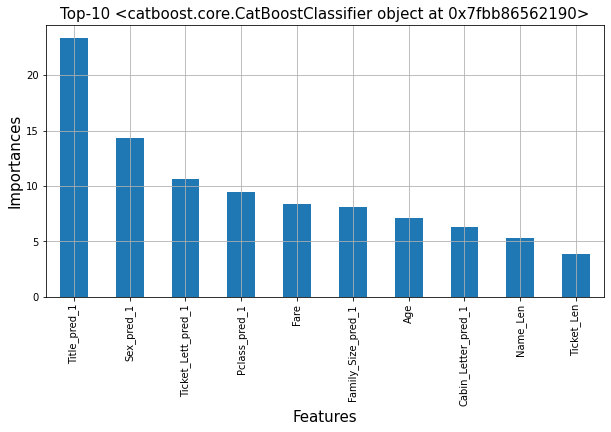

In [77]:
plot_feature_importances(rs.best_estimator_, X)

In [78]:
model = rs.best_estimator_
predictions_array = model.predict(test_encoded)
submission = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions_array})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### **2. RandomForest with Bayesian Optimization**

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
def rf_cv(n_estimators, min_samples_split, max_features, max_depth):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999), # float
            max_depth=int(max_depth),
            random_state=42
        ),
        train_encoded, train.iloc[:,0], scoring='roc_auc', cv=10
    ).mean()
    return val


In [80]:
from bayes_opt import BayesianOptimization
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (200, 1000),
        'min_samples_split': (2, 20),
        'max_features': (0.1, 0.999),
        'max_depth': (5, 15)}
    )

In [81]:
rf_bo.maximize()

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.8855   |  11.43    |  0.2045   |  4.076    |  677.4    |
|  2        |  0.8873   |  5.175    |  0.4401   |  2.718    |  347.4    |
|  3        |  0.8856   |  9.73     |  0.5496   |  2.914    |  852.3    |
|  4        |  0.8878   |  8.038    |  0.898    |  3.046    |  967.7    |
|  5        |  0.884    |  11.05    |  0.7321   |  2.144    |  347.2    |
|  6        |  0.8881   |  13.11    |  0.3751   |  6.15     |  746.1    |
|  7        |  0.8866   |  5.724    |  0.6037   |  7.333    |  273.0    |
|  8        |  0.8881   |  8.741    |  0.7317   |  15.52    |  717.4    |
|  9        |  0.889    |  10.77    |  0.5556   |  16.73    |  781.0    |
|  10       |  0.8889   |  12.08    |  0.5396   |  19.67    |  745.3    |
|  11       |  0.8876   |  7.117    |  0.8208   |  19.6     |  778.5    |
|  12       |  0.8888   |  10.24    | 

In [82]:
rf = RandomForestClassifier(max_depth=8,
                             n_estimators=905,
                             min_samples_split=14,
                             min_samples_leaf=1,
                             max_features=0.3964,
                             oob_score=True,
                             random_state=42,
                             n_jobs=-1)
rf.fit(X,y)
print("%.4f" % rf.oob_score_)

0.8350


In [83]:
submissions = rf.predict(test_encoded)
submissions = pd.DataFrame(submissions, columns=['Survived'])
submissions = pd.concat((test_data.iloc[:, 0], submissions), axis = 1)
submissions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [84]:
submission.to_csv('./submission.csv', index = False)

In [85]:
#train_df['AgeBand'] = pd.cut(train_df['Age'], 8)
#train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

Let us replace Age as oridinals based on these bands

In [86]:
#train_df.loc[ train_df['Age'] <= 11, 'Age'] = 0
#train_df.loc[(train_df['Age'] > 11) & (train_df['Age'] <= 21), 'Age'] = 1
#train_df.loc[(train_df['Age'] > 21) & (train_df['Age'] <= 31), 'Age'] = 2
#train_df.loc[(train_df['Age'] > 31) & (train_df['Age'] <= 41), 'Age'] = 3
#train_df.loc[(train_df['Age'] > 41) & (train_df['Age'] <= 51), 'Age'] = 4
#train_df.loc[(train_df['Age'] > 51) & (train_df['Age'] <= 61), 'Age'] = 5
#train_df.loc[(train_df['Age'] > 61) & (train_df['Age'] <= 71), 'Age'] = 6
#train_df.loc[ train_df['Age'] > 71, 'Age'] = 7

We can now remove the Ageband feature

In [87]:
#train_df = train_df.drop(['AgeBand'], axis=1)
#train_df.head()

We can now create a Fareband

In [88]:
#train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
#train_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

We can now convert the Fare feature to ordinal value.

In [89]:
#train_df.loc[ train_df['Fare'] <= 7.91, 'Fare'] = 0
#train_df.loc[(train_df['Fare'] > 7.91) & (train_df['Fare'] <= 14.454), 'Fare'] = 1
#train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare'] <= 31), 'Fare']   = 2
#train_df.loc[ train_df['Fare'] > 31, 'Fare'] = 3
#train_df['Fare'] = train_df['Fare'].astype(int)
#train_data = train_data.drop(['FareBand'], axis=1)
#train_df.head(10)

**Transform ticket into ticket occurrences**

In [90]:
#train_df['TicketOccurrences'] = 1
#train_df['TicketOccurrences'] = train_df[['Ticket', 'TicketOccurrences']].groupby(['Ticket']).transform(lambda t: t.count())

#train_df = train_df.drop(['Ticket'], axis=1)
#train_df.head(4)

In [91]:
#train_df[['TicketOccurrences', 'Survived']].groupby(['TicketOccurrences'], as_index=False).mean().sort_values(by='Survived', ascending=False)

**One Hot encode Cabin**

In [92]:
#train_df['Section'] = train_df['Cabin'].transform(lambda c: c.str.extract('^([A-Za-z])', expand=False))

#train_df['Section'] = train_df['Section'].fillna('Unknown')

#train_df = pd.get_dummies(train_df, columns=['Section'], sparse=True)

#train_df = train_df.drop(['Cabin'], axis=1)

Create an artificial feature combining Pclass and Age.

In [93]:
#for dataset in combine:
 #   dataset['Age*Class'] = dataset.Age * dataset.Pclass

In [94]:
#X_train = train_df.drop("Survived", axis=1)
#Y_train = train_df["Survived"]
#X_test  = test_data.drop("PassengerId", axis=1).copy()
#X_train.shape, Y_train.shape, X_val.shape, Y_val.shape,  X_test.shape

In [95]:
#from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
#model.fit(X_train, Y_train)
#predictions = model.predict(X_test)

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('my_submission.csv', index=False)
#print("Your submission was successfully saved!")

In [96]:
#acc_random_forest = round(model.score(X_train, Y_train) * 100, 2)
#acc_random_forest

In [97]:
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression()
#logreg.fit(X_train, Y_train)
#Y_pred = logreg.predict(X_test)


#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred})
#output.to_csv('my_submission.csv', index=False)
#print("Your submission was successfully saved!")

In [98]:
#acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
#acc_log

In [99]:
#from sklearn.svm import SVC, LinearSVC
#svc = SVC()
#svc.fit(X_train, Y_train)
#Y_pred = svc.predict(X_test)

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred})
#output.to_csv('my_submission.csv', index=False)
#print("Your submission was successfully saved!")

In [100]:
#acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
#acc_svc

In [101]:
#from sklearn.linear_model import SGDClassifier
#sgd = SGDClassifier()
#sgd.fit(X_train, Y_train)
#Y_pred = sgd.predict(X_test)


In [102]:
#acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
#acc_sgd

In [103]:
#from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors = 3)
#knn.fit(X_train, Y_train)
#Y_pred = knn.predict(X_test)
#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred})
#output.to_csv('my_submission.csv', index=False)
#print("Your submission was successfully saved!")

In [104]:
#acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
#acc_knn

In [105]:
#from sklearn.naive_bayes import GaussianNB
#gaussian = GaussianNB()
#gaussian.fit(X_train, Y_train)
#Y_pred = gaussian.predict(X_test)


In [106]:
#acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
#acc_gaussian

In [107]:
#from sklearn.linear_model import Perceptron
#perceptron = Perceptron()
#perceptron.fit(X_train, Y_train)
#Y_pred = perceptron.predict(X_test)
#acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
#acc_perceptron

In [108]:
#from sklearn.tree import DecisionTreeClassifier
#decision_tree = DecisionTreeClassifier()
#decision_tree.fit(X_train, Y_train)
#Y_pred = decision_tree.predict(X_test)

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred})
#output.to_csv('my_submission.csv', index=False)
#print("Your submission was successfully saved!")

In [109]:
#acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
#acc_decision_tree

In [110]:
#from sklearn.metrics import confusion_matrix
#import itertools

#decision_tree = DecisionTreeClassifier()
#decision_tree.fit(X_train, Y_train)
#Y_pred = decision_tree.predict(X_train)

# Compute confusion matrix
#cnf_matrix = confusion_matrix(Y_train, Y_pred)
#np.set_printoptions(precision=2)

#print ('Confusion Matrix in Numbers')
#print (cnf_matrix)
#print ('')

#cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

#print ('Confusion Matrix in Percentage')
#print (cnf_matrix_percent)
#print ('')

#true_class_names = ['True Survived', 'True Not Survived']
#predicted_class_names = ['Predicted Survived', 'Predicted Not Survived']

#df_cnf_matrix = pd.DataFrame(cnf_matrix, 
#                             index = true_class_names,
#                             columns = predicted_class_names)

#df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
#                                     index = true_class_names,
#                                     columns = predicted_class_names)

#plt.figure(figsize = (15,5))

#plt.subplot(121)
#sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

#plt.subplot(122)
#sns.heatmap(df_cnf_matrix_percent, annot=True)

In [111]:
#models = pd.DataFrame({
#    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
#              'Random Forest', 'Naive Bayes', 'Perceptron', 
#              'Stochastic Gradient Decent', 'Decision Tree'],
#    'Score': [acc_svc, acc_knn, acc_log, 
#              acc_random_forest, acc_gaussian, acc_perceptron, 
#              acc_sgd, acc_decision_tree]})
#models.sort_values(by='Score', ascending=False)